## TOC Extraction & Contextual Embedding from PDF with easyparser

In [1]:
from pathlib import Path
pdf_path = str(Path.cwd().parent / "tests" / "assets" / "long.pdf")

In [ ]:
from easyparser.base import CType, Chunk, ChunkGroup
from easyparser.controller import Controller
from easyparser.parser.pdf import FastPDF
from easyparser.split.toc_builder import TOCBuilder

# load the PDF file with easyparser
ctrl = Controller()
root = ctrl.as_root_chunk(pdf_path)
chunks: ChunkGroup = FastPDF.run(
    root, 
    use_layout_parser=True,
)
# print the chunks graph
new_root: Chunk = chunks[0]
new_root.print_graph()

2025-05-16 07:59:28,186 - DownloadModel - INFO: /Users/taprosoft/miniconda3/lib/python3.12/site-packages/rapid_layout/models/yolov8n_layout_general6.onnx already exists
2025-05-16 07:59:28,221 - rapid_layout - INFO: yolov8n_layout_general6 contains ['Text', 'Title', 'Figure', 'Table', 'Caption', 'Equation']


 Chunk(ctype=root, content=File /Users/taprosoft/Shared/debug/chunking/tests/assets/long.pdf)
     Chunk(ctype=figure, mimetype=image/png)
     Chunk(ctype=header, content=DeepSeek-V3 Technical Report)
     Chunk(ctype=para, content=DeepSeek-AI)
     Chunk(ctype=para, content=research@deepseek.com)
     Chunk(ctype=header, content=Abstract)
     Chunk(ctype=para, content=We present DeepSeek-V3, a strong Mixture-of-Expert... (142 more words))
     Chunk(ctype=figure, mimetype=image/png)
     Chunk(ctype=para, content=Figure 1 | Benchmark performance of DeepSeek-V3 and its counterparts.)
     Chunk(ctype=para, content=arXiv:2412.19437v1 [cs.CL] 27 Dec 2024)
     Chunk(ctype=header, content=Contents)
     Chunk(ctype=para, content=**1 Introduction 4**)
     Chunk(ctype=table, mimetype=image/png)
     Chunk(ctype=para, content=4.5.2 Ablation Studies for the Auxiliary-Loss-Free... (10 more words))
     Chunk(ctype=para, content=4.5.3 Batch-Wise Load Balance VS. Sequence-Wise Lo... (12 more 

Using TOC Builder to create hierachy from headers and chunks

In [3]:
# specify the LLM model name to use for TOC building
# in this case you might have to setup GEMINI API key
# os.environ["GEMINI_API_KEY"] = "your_gemini_api_key"
model = "gemini-2.5-flash-preview-04-17"
chunks = TOCBuilder.run(
    chunks,
    use_llm=True,
    model=model,
)
new_root: Chunk = chunks[0]
new_root.print_graph(ctype=CType.Header)

     Chunk(ctype=header, content=DeepSeek-V3 Technical Report)
     Chunk(ctype=header, content=Abstract)
     Chunk(ctype=header, content=Contents)
     Chunk(ctype=header, content=1. Introduction)
     Chunk(ctype=header, content=2. Architecture)
         Chunk(ctype=header, content=2.1. Basic Architecture)
             Chunk(ctype=header, content=2.1.1. Multi-Head Latent Attention)
             Chunk(ctype=header, content=2.1.2. DeepSeekMoE with Auxiliary-Loss-Free Load Balancing)
         Chunk(ctype=header, content=2.2. Multi-Token Prediction)
     Chunk(ctype=header, content=3. Infrastructures)
         Chunk(ctype=header, content=3.1. Compute Clusters)
         Chunk(ctype=header, content=3.2. Training Framework)
             Chunk(ctype=header, content=3.2.1. DualPipe and Computation-Communication Overlap)
             Chunk(ctype=header, content=3.2.3. Extremely Memory Saving with Minimal Overhead)
         Chunk(ctype=header, content=3.3. FP8 Training)
             Chunk(ctyp

Use TOC and surrounding chunks for contextual explaination and embedding

In [8]:
table_chunks = new_root.find_all(ctype=CType.Table)
selected_table_chunk = table_chunks[3]
print(selected_table_chunk.text)

```table
     Method                           Bubble                     Parameter            Activation

       1F1B                       ( 𝑃𝑃 − 1 )  ( 𝐹 + 𝐵 )           1 ×                  𝑃𝑃

       ZB1P                    ( 𝑃𝑃 − 1 )  ( 𝐹 + 𝐵 − 2 𝑊 )       1 ×                  𝑃𝑃
                              𝑃𝑃
 DualPipe    (Ours)          (   −  1 )  ( 𝐹 & 𝐵 + 𝐵 − 3 𝑊 )      2 ×                𝑃𝑃 + 1
                               2
```


In [15]:
print("prev", selected_table_chunk.prev)
print("next", selected_table_chunk.next)
print("parent", selected_table_chunk.parent)

toc_content = "\n".join(c.content for c in new_root.find_all(ctype=CType.Header))
print("TOC content:")
print(toc_content)

prev Chunk(ctype=para, content=Figure 5 | Example DualPipe scheduling for 8 PP ra... (44 more words))
next Chunk(ctype=para, content=Table 2 | Comparison of pipeline bubbles and memor... (51 more words))
parent Chunk(ctype=header, content=3.2.1. DualPipe and Computation-Communication Overlap)
TOC content:
DeepSeek-V3 Technical Report
Abstract
Contents
1. Introduction
2. Architecture
2.1. Basic Architecture
2.1.1. Multi-Head Latent Attention
2.1.2. DeepSeekMoE with Auxiliary-Loss-Free Load Balancing
2.2. Multi-Token Prediction
3. Infrastructures
3.1. Compute Clusters
3.2. Training Framework
3.2.1. DualPipe and Computation-Communication Overlap
3.2.3. Extremely Memory Saving with Minimal Overhead
3.3. FP8 Training
3.3.1. Mixed Precision Framework
3.3.2. Improved Precision from Quantization and Multiplication
3.3.3. Low-Precision Storage and Communication
3.4. Inference and Deployment
3.4.1. Prefilling
3.4.2. Decoding
3.5. Suggestions on Hardware Design
3.5.1. Communication Hardware
3.5.2

Generate contextual summary using LLM

Based on the idea in https://www.anthropic.com/news/contextual-retrieval

In [22]:
# use LLM to generate contextual summary of this table 
# based on surrounding chunks and headers
from easyparser.models import completion
PROMPT = """
<document> 
{WHOLE_DOCUMENT}
</document> 
Here is the chunk we want to situate within the whole document 
<chunk> 
{CHUNK_CONTENT}
</chunk> 
Surrounding chunks are:
<surrounding_chunks>
{SURROUNDING_CONTENT}
</surrounding_chunks>
Parent chunk is:
<parent_chunk>
{PARENT_CONTENT}
</parent_chunk>
Please give a concise summary of this chunk content and its relation within the overall document for the purposes of improving search retrieval of the chunk. Answer only with the summary and nothing else. 
"""

contextual_summary = completion(
    model=model,
    message=PROMPT.format(
        WHOLE_DOCUMENT=toc_content,
        CHUNK_CONTENT=selected_table_chunk.text,
        SURROUNDING_CONTENT=(
            selected_table_chunk.prev.content
            + "\n" 
            + selected_table_chunk.next.content
        ),
        PARENT_CONTENT=selected_table_chunk.parent.content,
    ),
)
print("Contextual summary:")
print(contextual_summary)

Contextual summary:
This chunk contains Table 2, which compares different pipeline parallel methods (1F1B, ZB1P, and DualPipe) based on pipeline bubble time, parameter memory, and activation memory usage. It demonstrates the memory efficiency and overlap benefits of the DualPipe method, as discussed in its parent section (3.2.1) on DualPipe and computation-communication overlap, which is part of the broader Infrastructures section (3) detailing the training setup for DeepSeek-V3.


We can do the same for figure to get more contextual information

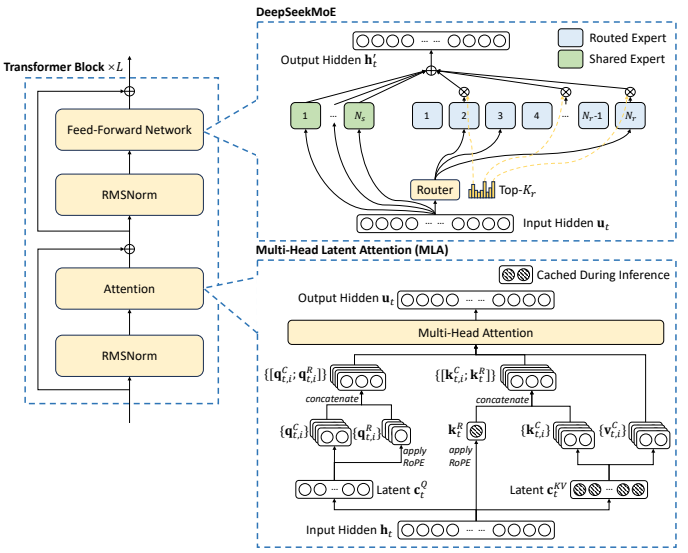

In [27]:
figure_chunks = new_root.find_all(ctype=CType.Figure)
selected_figure_chunk = figure_chunks[2]
rendered_item = selected_figure_chunk.render(format="multi")[0]
rendered_item["content"]

In [28]:
import llm

contextual_summary = completion(
    model=model,
    message=PROMPT.format(
        WHOLE_DOCUMENT=toc_content,
        CHUNK_CONTENT=selected_figure_chunk.text,
        SURROUNDING_CONTENT=(
            selected_figure_chunk.prev.content
            + "\n" 
            + selected_figure_chunk.next.content
        ),
        PARENT_CONTENT=selected_figure_chunk.parent.content,
    ),
    attachments=[
        llm.Attachment(
            type=selected_figure_chunk.mimetype,
            content=selected_figure_chunk.content
        ),
    ]
)
print("Contextual summary:")
print(contextual_summary)

Contextual summary:
This figure illustrates the basic architecture of DeepSeek-V3, detailing the Transformer block components including RMSNorm, Attention, and Feed-Forward Network. It specifically shows the Multi-Head Latent Attention (MLA) mechanism with latent queries, keys, and values, incorporating RoPE and caching during inference, and the DeepSeekMoE structure which uses a Router to select and combine outputs from Shared and Routed Experts based on the input hidden state. This diagram visually supports the descriptions in section 2.1 regarding the model's fundamental building blocks, MLA, and DeepSeekMoE.
